In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle

In [2]:
def get_batch(X, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a]

class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch=1000, batch_size=50, learning_rate=0.001):
        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.sigmoid(tf.matmul(x, weights) + biases)
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases

        self.x = x
        self.encoded = encoded
        self.decoded = decoded

        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        
        self.saver = tf.train.Saver()

    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                for j in range(np.shape(data)[0] // self.batch_size):
                    batch_data = get_batch(data, self.batch_size)
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
                if i % 10 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
            self.saver.save(sess, './model.ckpt')
        
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
            reconstructed = reconstructed[0]
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden

    def decode(self, encoding):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            reconstructed = sess.run(self.decoded, feed_dict={self.encoded: encoding})
        img = np.reshape(reconstructed, (32, 32))
        return img


In [3]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [4]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [5]:
names = unpickle('./cifar-10-batches-py/batches.meta')['label_names']
data, labels = [], []
for i in range(1, 6):
    filename = './cifar-10-batches-py/data_batch_' + str(i)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']

In [6]:
data = grayscale(data)

In [7]:
x = np.matrix(data)
y = np.array(labels)
print(np.shape(x))
print(y)

(50000, 1024)
[6 9 9 ... 9 1 1]


In [10]:
horse_indices = np.where(y == 7)[0]
horse_x = x[horse_indices]
print(np.shape(horse_x))  # (5000, 3072)

(5000, 1024)


Some examples of horse images we will feed to the autoencoder for training


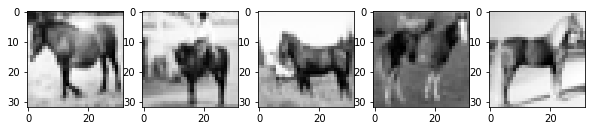

In [11]:
print('Some examples of horse images we will feed to the autoencoder for training')
plt.rcParams['figure.figsize'] = (10, 10)
num_examples = 5
for i in range(num_examples):
    horse_img = np.reshape(horse_x[i, :], (32, 32))
    plt.subplot(1, num_examples, i+1)
    plt.imshow(horse_img, cmap='Greys_r')
plt.show()

In [9]:
input_dim = np.shape(horse_x)[1]
hidden_dim = 100
ae = Autoencoder(input_dim, hidden_dim)
ae.train(horse_x)

(5000, 1024)
Instructions for updating:
Colocations handled automatically by placer.
epoch 0: loss = 131.9862823486328
epoch 10: loss = 72.3276138305664
epoch 20: loss = 59.78321838378906
epoch 30: loss = 60.273502349853516
epoch 40: loss = 58.18358612060547
epoch 50: loss = 58.844112396240234
epoch 60: loss = 56.254817962646484
epoch 70: loss = 56.89329528808594
epoch 80: loss = 55.61947250366211
epoch 90: loss = 54.59465026855469
epoch 100: loss = 54.35457229614258
epoch 110: loss = 52.358428955078125
epoch 120: loss = 52.94954299926758
epoch 130: loss = 53.385345458984375
epoch 140: loss = 50.08681869506836
epoch 150: loss = 50.72406005859375
epoch 160: loss = 53.562591552734375
epoch 170: loss = 52.461326599121094
epoch 180: loss = 51.339752197265625
epoch 190: loss = 54.80295181274414
epoch 200: loss = 52.6483154296875
epoch 210: loss = 50.621456146240234
epoch 220: loss = 48.94619369506836
epoch 230: loss = 52.055667877197266
epoch 240: loss = 48.976558685302734
epoch 250: loss =

In [12]:
test_data = unpickle('./cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])
encodings = ae.classify(test_x, test_labels)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt
data (10000, 1024)
reconstructed (1024,)
loss (10000,)
horse 61.94310091237028
not horse 60.69143978599256


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

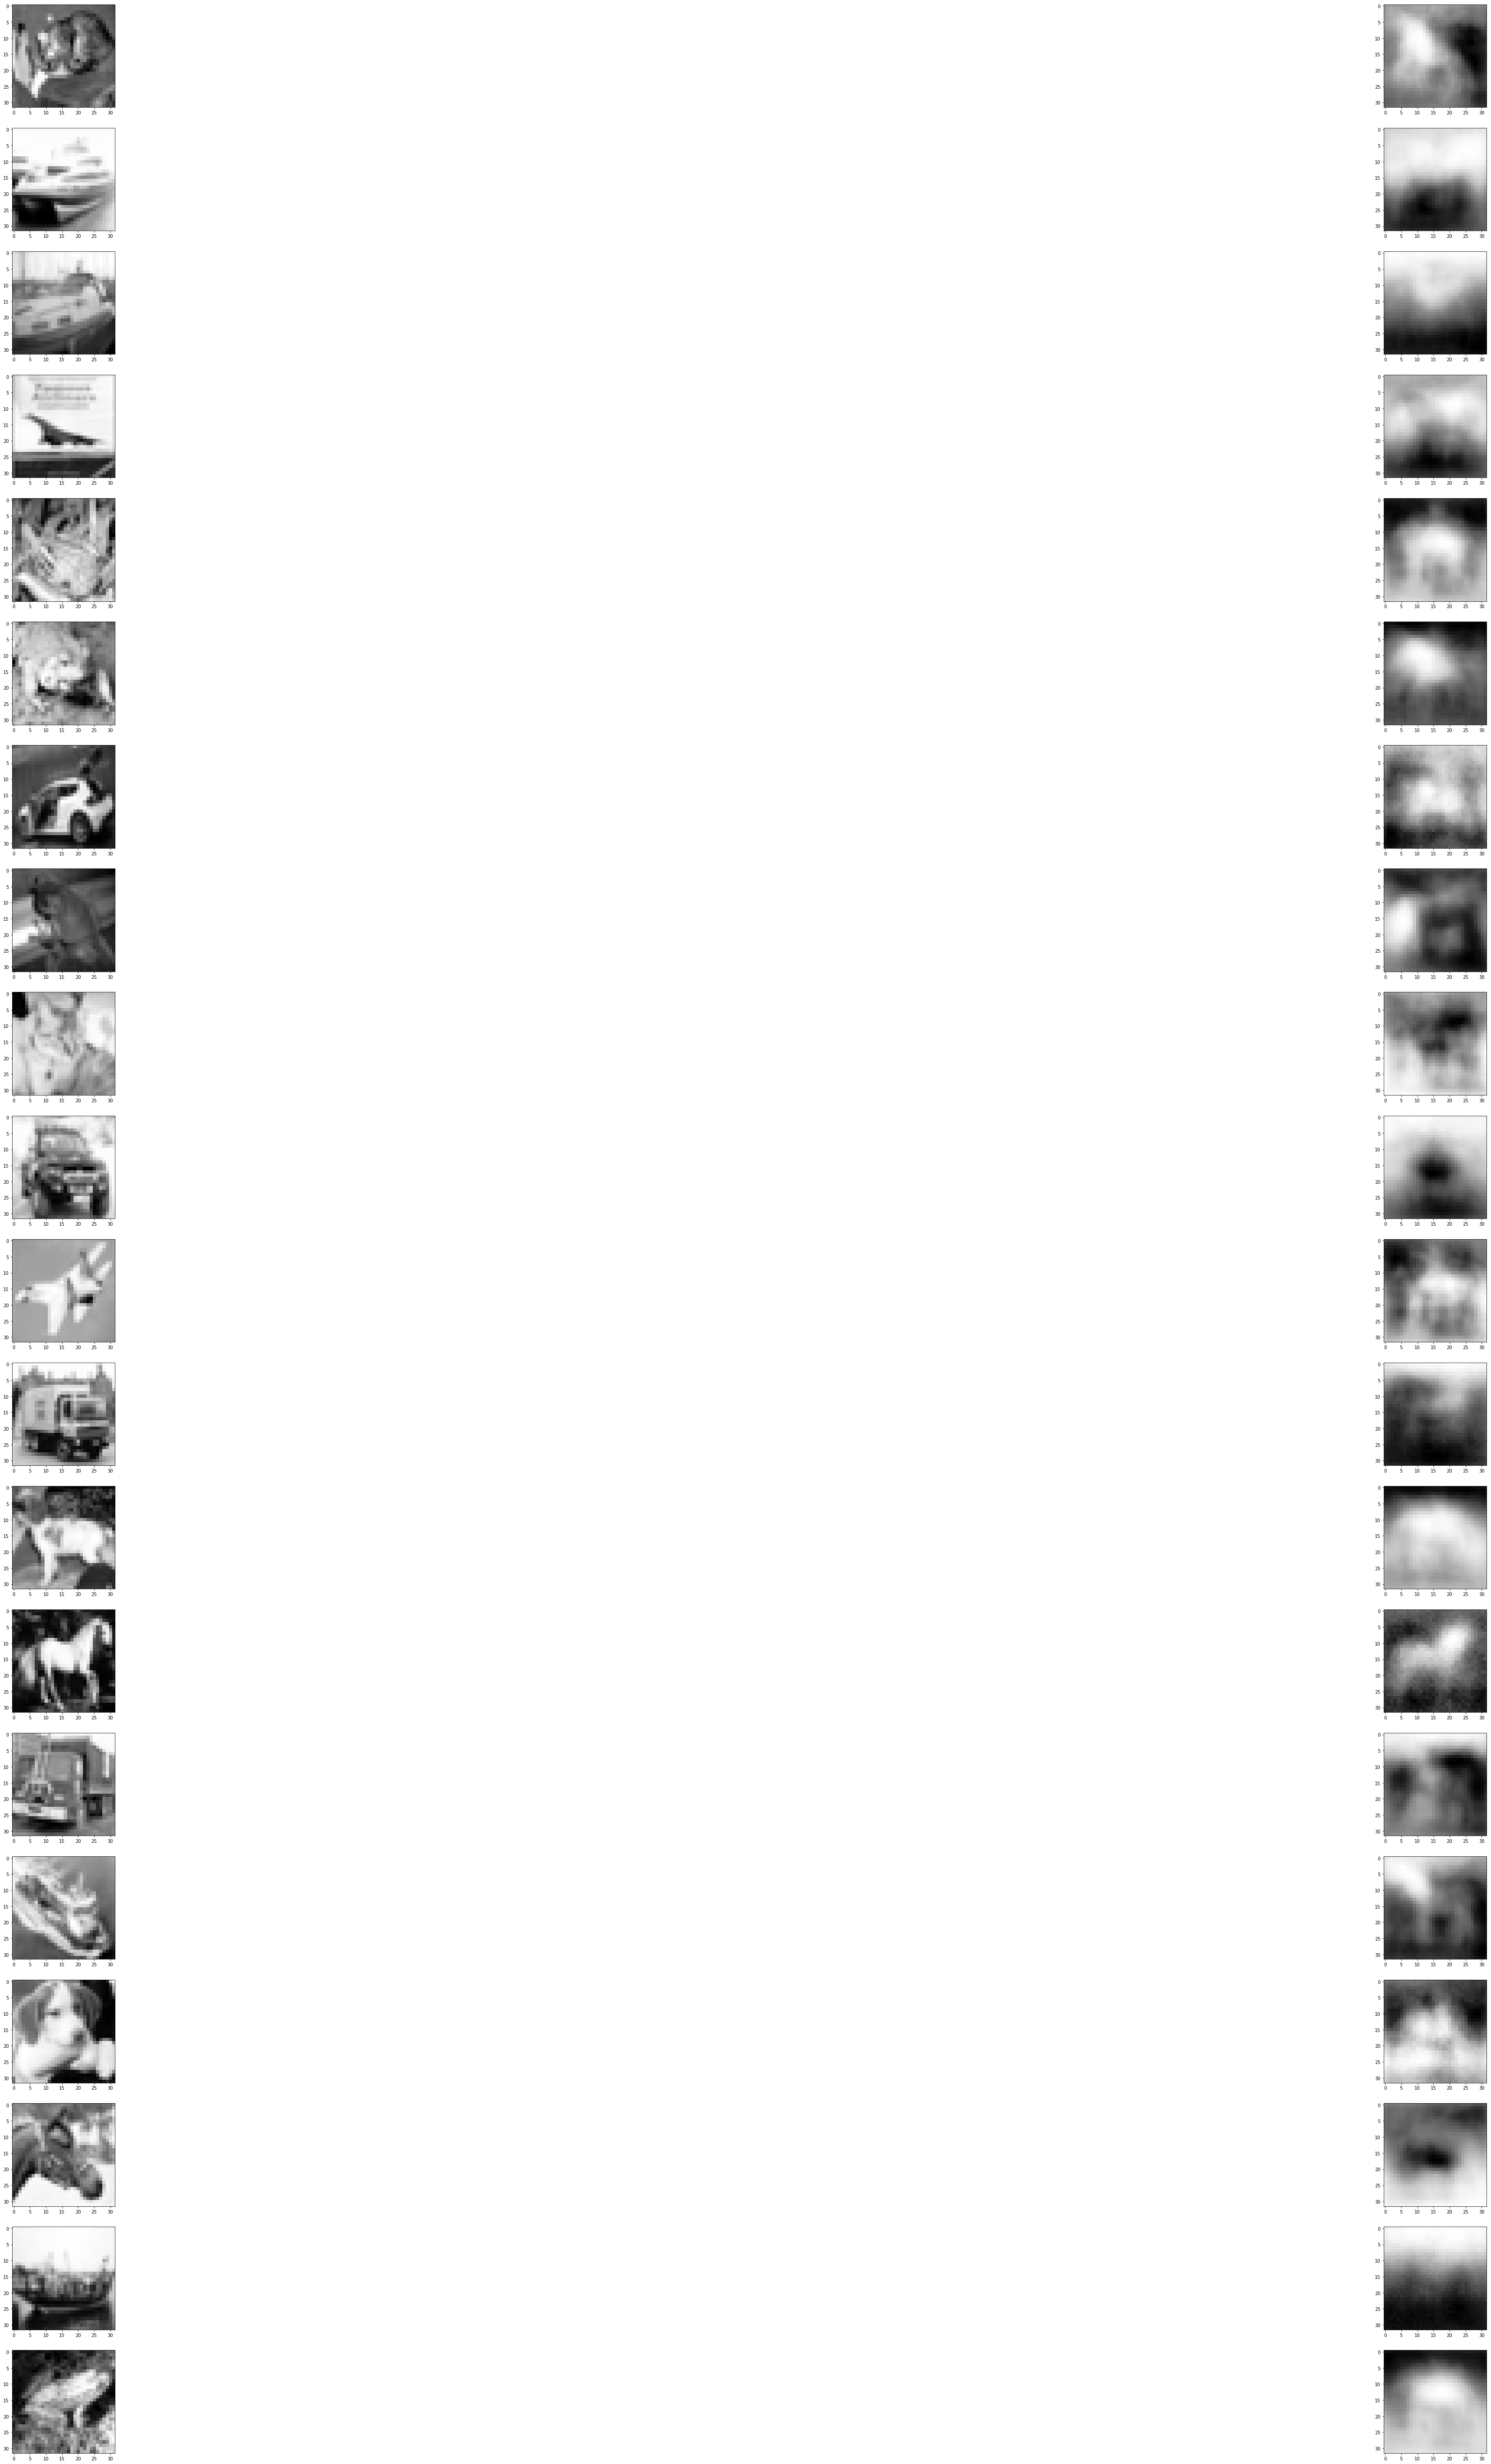

In [13]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_x[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = ae.decode([encodings[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show()